# NLP21@BGU.CS - HW1

## Michael Elhadad michael.elhadad@example.com
### NLP 2021 - HW1 (http://www.cs.bgu.ac.il/~elhadad/nlp21/hw1.html)

**Yael jannai** - 316418656 


**Shani Klein** - 205781909

Nov 2020

In [1]:
# Boring preliminaries
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division
import nltk
import pandas as pd
import builtins
from nltk.util import ngrams 
import numpy as np
import matplotlib.pyplot as plt
import math
import string
import os
nltk.download('punkt')


Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# helper class to print nice outputs
class txt:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def make_bold(text):
    return txt.BOLD+ text + txt.END

def make_underline(text):
    return txt.UNDERLINE+ text + txt.END

<h2>Content</h2>

* <a href="#P1">Part 1: Language Models</a>
  * <a href="#data">1.1 Data Exploration</a>
    * <a href="#explore">1.1.1 Gathering basic statistics</a>
    * <a href="#power">1.1.2 Zipf and Power Law</a>
  * <a href="#ngram">1.2 n-gram model</a>
    * <a href="#n_parameters">1.2.1 How much memory do you expect a model to occupy?</a>
    * <a href="#train_lm">1.2.2 N-gram Word LM</a>
  * <a href="#eval">1.3 Language Model Evaluation</a>
    * <a href="#per">1.3.1 Perplexity</a>
    * <a href="#smoothing">1.3.2 Smoothing</a>
    * <a href="#overfit">1.3.3 Perplexity according to the order of the n-gram model
    * <a href="#test-lm">1.3.4 Test the best n-gram LM</a>
    * <a href="#gen">1.3.5 Generating Text using Language Models</a>
  * <a href="#nn-lm">1.4 Character language model</a>
    * <a href="#effectiveness">1.4.1 Read and Summarize</a>
    * <a href="#recipes">1.4.2 Recipes with a Character LM</a>
* <a href="#P2">Part 2: Polynomial curve fitting</a>
  * <a href="#syntheticdata">2.1 Synthetic data generation</a>
  * <a href="#curvefitting">2.2 Polynomial Curve Fitting</a>
  * <a href="#regularization">2.3 Polynomial Curve Fitting with Regularization</a>
  * <a href="#prob-regr">2.4 Probabilistic Regression Model</a>
* <a href="#P3">Part 3: Text Classification with Character RNN</a>
  * <a href="#readtut">3.1 Summarize the PyTorch Tutorial</a>
  * <a href="#newdata">3.2 Explore the Cities Dataset</a>
  * <a href="#citiesmodel">3.3 Train and Evaluate the RNN Model for Cities</a>
  * <a href="#bettercitiesmodel">3.4 (Optional) Improve the Model</a>

<hr>
<a name="P1"></a>
<h2>Part 1: Language Models</h2>

<a name="data"></a>
<h3>1.1 Data Exploration</h3>

<a name="explore"></a>
<h4>1.1.1 Gathering Basic Statistics</h4>

In this section, we collect and plot the following information on a text dataset:
<ul>
<li>The total number of tokens</li>
<li>The total number of characters</li>
<li>The total number of distinct words (vocabulary)</li>
<li>The total number of tokens corresponding to the top-N most frequent words in the vocabulary</li>
<li>The token/type ratio in the dataset</li>
<li>The number of types that appear in the dev data but not the training data</li>
<li>The average number and standard deviation of characters per token</li>
<li>The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.</li>
<li>The total number of distint n-grams of characters that appear for n=2,3,4,5,6,7.</li>
</ul>

We operate on the PTB dataset, which contains 929k training words, 73k validation words, and 82k test words. 
It is formatted in such a way that only the top 10k most frequent words are in its vocabulary.

We gather the files from <a href="http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz">the dataset</a>
where sentences are segmented one per line and words separated by spaces.  We assume the files are located in "../data/".

###### The data set
First, we created a dictionary of all datasets we got

In [90]:
data = {
    "char_train": '../data/ptb.char.train.txt',
    "char_valid": '../data/ptb.char.valid.txt',
    "char_test": '../data/ptb.char.test.txt',
    "ptb_train": '../data/ptb.train.txt',
    "ptb_valid":'../data/ptb.valid.txt',
    "ptb_test": '../data/ptb.test.txt',
    "shakespeare":'../data/shakespeare_input.txt'
}

You may need to tokenize strings read from the dataset files into lists of tokens.  
Think which method is best appropriate for this dataset given the way it is formatting.
Recall the method based on regular expressions used in Norvig's piece.
Compare it with the the tokenizer provided in the nltk library.

##### Gathering Basic Statistics

First we wrote some function to get statistics from texts

In [4]:
# remove tokens we don't want such as puncuation marks"
def fix_token(token):
    if token.isalpha() or token.find('-')!=-1 :
        return token
    return None

# if we need to clean punctuation
def get_tokens_no_punc(text):
    tokens = nltk.word_tokenize(text)
    # remove  all tokens that are not alphabetic i.e '<' , '$' , ect .
    tokens = [token for token in tokens if fix_token(token)!=None]
    return tokens

# the default nltk way to tokenize text
def get_tokens(text):
    return nltk.word_tokenize(text)
 
# for debbuging - we define function that prints the first num_of_tokens tokens
def print_tokens(text,num_of_tokens,clean=0):
    tokens=get_tokens(text)
    print(tokens[0:num_of_tokens])

# To compute distinct word we used the set method which store multiple instance of words as one variable
def get_vocabulary(text,clean=0):
    tokens=get_tokens(text) if clean==0 else get_tokens_no_punc(text)
    return set(tokens)

# return top-N most frequent words in the vocabulary
# We used nltk built-in methods
def N_most_frequent(text,N,clean=0):
    tokens=get_tokens(text) if clean==0 else get_tokens_no_punc(text)
    fdist = nltk.FreqDist(tokens)
    return fdist.most_common(N)

# returs the all distinct n-grams of words
def get_ngrams_words(text,num,clean=0):
    tokens=get_tokens(text) if clean==0 else get_tokens_no_punc(text)
#   text.split() we seperate the ngrams into words instead of chars
    return Counter(ngrams(tokens, num))

# returs all number of distinct n-grams of chars
def get_ngrams_chars(text,num):
    return Counter(ngrams(text.replace(' ',''), num))

Let's check our function on a simple text

In [5]:
text = "hi! I'm happy you're here! this is a simple text. it is maybe simple text but it is important! bye-bye"
print(make_bold("default tokenizer: ")+ str(get_tokens(text)),\
    make_bold("clean tokens: ")+ str(get_tokens_no_punc(text)),\
    make_bold("default vocab: ")+str(get_vocabulary(text)),\
    make_bold("clean vocab: ")+str(get_vocabulary(text,1)),\
    make_bold("default 3 most frequent")+str(N_most_frequent(text,3)),\
    make_bold("clean 3 most frequent")+str(N_most_frequent(text,3,1)),\
    make_bold("defualt 3-gram words: ")+str(get_ngrams_words(text,3)),\
    make_bold("clean 3-gram words: ")+str(get_ngrams_words(text,3,1)),\

    sep='\n\n')

default tokenizer: ['hi', '!', 'I', "'m", 'happy', 'you', "'re", 'here', '!', 'this', 'is', 'a', 'simple', 'text', '.', 'it', 'is', 'maybe', 'simple', 'text', 'but', 'it', 'is', 'important', '!', 'bye-bye']

clean tokens: ['hi', 'I', 'happy', 'you', 'here', 'this', 'is', 'a', 'simple', 'text', 'it', 'is', 'maybe', 'simple', 'text', 'but', 'it', 'is', 'important', 'bye-bye']

default vocab: {'maybe', 'but', 'happy', 'a', '!', "'m", 'bye-bye', 'this', 'text', 'is', 'hi', 'you', '.', 'it', 'important', 'here', 'I', "'re", 'simple'}

clean vocab: {'a', 'hi', 'you', 'it', 'important', 'here', 'I', 'this', 'bye-bye', 'text', 'maybe', 'is', 'but', 'happy', 'simple'}

default 3 most frequent[('!', 3), ('is', 3), ('simple', 2)]

clean 3 most frequent[('is', 3), ('simple', 2), ('text', 2)]

defualt 3-gram words: Counter({('hi', '!', 'I'): 1, ('!', 'I', "'m"): 1, ('I', "'m", 'happy'): 1, ("'m", 'happy', 'you'): 1, ('happy', 'you', "'re"): 1, ('you', "'re", 'here'): 1, ("'re", 'here', '!'): 1, ('h

We can tell that if we clean the text we get differrent and better results!
For exmaple, instead of I'm to become 2 tokens of I and 'm we just keep the I as token

Next, we define helper methods to compute the total number of distinct words (the vocabulary) and the total number of tokens corresponding to the top-N most frequent words in the vocabulary

let's check our function  on different values of N

In [6]:
# helper function to get all texe of file fname
def get_text(fname):
    file=open(fname,'rt')
    text=file.read()
    file.close()
    return text

In [7]:
def get_stats(text_train,text_dev=None):
    tokens_train=get_tokens(text_train)
    # total num of token, num of chars and num of distinct words
    num_of_tokens=len(tokens_train)
    num_of_chars= len(text_train)
    vocab_size= len(get_vocabulary(text_train))
    # 5 most frequent words (we chose 5 for the example)
    ten_most_frequent=builtins.sum(freq[1] for freq in N_most_frequent(text,5))
    # The token/type ratio in the dataset
    token_per_type_ratio= num_of_tokens/vocab_size
    # The number of types that appear in the dev data but not the training data
    types_in_dev_not_train=len(np.setdiff1d(get_vocabulary(text_dev),get_vocabulary(text_train))[0])\
    if text_dev!=0 else "no dev in this stats"
    # # The average number and standard deviation of characters per token
    chars_per_token = [len(w) for w in tokens_train]
    mean_char_per_tok= np.mean(chars_per_token)
    std_char_per_tok=np.std(chars_per_token)
    # The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.

    # prints all the data whe gathered until now
    print(make_bold('The total number of tokens: ') + str(num_of_tokens) \
          ,make_bold ('Total number of characters: ')+ str(num_of_chars) \
          ,make_bold('Total number of distinct words: ')+ str(vocab_size) \
          ,make_bold('Total number of tokens corresponding to the top-5 most frequent words: ') +str(ten_most_frequent)\
          ,make_bold('token/type ratio: '),str(token_per_type_ratio)\
          ,make_bold('Number of types that appear in the dev data but not the training data: ') + str(types_in_dev_not_train)\
          ,make_bold('total number of tokens corresponding to the top-10 most frequent words: ')+str(ten_most_frequent)\
          ,make_bold('token/type ratio in the dataset: ')+str(token_per_type_ratio)\
          ,make_bold('average number of characters per token: ')+str(mean_char_per_tok)\
          ,make_bold('standard deviation of characters per token: ')+str(std_char_per_tok)\
          ,sep='\n')

    print(make_bold('\n number of distinct n-grams of words:'))
    # The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.
    for n in [2,3,4]:
            print(make_underline('\tn='+ str(n)+':'),len(get_ngrams_words(text,n)))

    print(make_bold('\n number of distinct n-grams of characters:'))
    for n in [2,3,4,5,6,7]:
            print(make_underline('\tn='+ str(n)+':'),len(get_ngrams_chars(text,n)))


let's check our statistic on ptb

In [8]:
text_train=get_text(data['ptb_train'])
text_dev=get_text(data['ptb_valid'])
get_stats(text_train,text_dev)

The total number of tokens: 978754
Total number of characters: 5101618
Total number of distinct words: 9996
Total number of tokens corresponding to the top-5 most frequent words: 12
token/type ratio: 
97.91456582633053
Number of types that appear in the dev data but not the training data: 6020
total number of tokens corresponding to the top-10 most frequent words: 12
token/type ratio in the dataset: 97.91456582633053
average number of characters per token: 4.2196108521651
standard deviation of characters per token: 2.705689094054091

 number of distinct n-grams of words:
	n=2: 23
	n=3: 24
	n=4: 23

 number of distinct n-grams of characters:
	n=2: 59
	n=3: 67
	n=4: 71
	n=5: 73
	n=6: 73
	n=7: 73


Now let's test shakepseare:

In [9]:
text_sh=str(get_text(data['shakespeare']).split('\n'))
get_stats(text_sh,text_dev)


The total number of tokens: 1409962
Total number of characters: 5074954
Total number of distinct words: 35263
Total number of tokens corresponding to the top-5 most frequent words: 12
token/type ratio: 
39.98417604854947
Number of types that appear in the dev data but not the training data: 6020
total number of tokens corresponding to the top-10 most frequent words: 12
token/type ratio in the dataset: 39.98417604854947
average number of characters per token: 3.0162160398649043
standard deviation of characters per token: 2.2717230852191777

 number of distinct n-grams of words:
	n=2: 23
	n=3: 24
	n=4: 23

 number of distinct n-grams of characters:
	n=2: 59
	n=3: 67
	n=4: 71
	n=5: 73
	n=6: 73
	n=7: 73


Note how abbreviations in English are tokenized in PTB ("I'm" becomes ["I", "'m"]) and numbers are all replaced by the "N" special token.

<a name="power"></a>
<h4>1.1.2 Zipf and Power Law</h4>

Word count distributions are said to follow <a href="https://en.wikipedia.org/wiki/Power_law">power law distributions</a>. 
In practice, this means that a plot of the log-frequency against the log-rank is nearly linear. 
We will verify that this holds for the Penn Treebank dataset by constructing the appropriate corpus_counts counter:


In [10]:
text=get_text(data['ptb_train'])
tokens = get_tokens(text)
corpus_counts = Counter(tokens)

3.3.2


Text(0, 0.5, 'frequency')

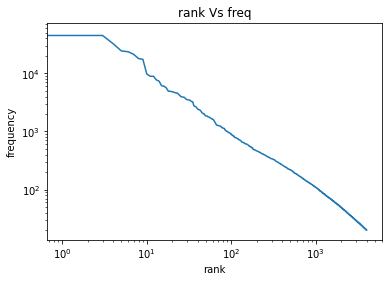

In [11]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)

plt.loglog([val for word,val in corpus_counts.most_common(4000)])
plt.title('rank Vs freq')
plt.xlabel('rank')
plt.ylabel('frequency')


As predicted - we got nearly linear graph .
The results make sense because the rank and frequency are proportional to each other .

<a name="ngram"></a>
<h3><a name="ngram">1.2 n-gram Word Language Model</a></h3>

<a name="n_parameters"></a>
<h4>1.2.1 How much memory do you expect a model to occupy?</h4>


###### Solution:
First of all if we notice  the statistics result above we  can tell that as  n growth so the number of n-grams (either characters or words). hence we expect our model to grow according to n .

but let's get mor precise answer:
For our model we need to keep a dictionary of dictionaries  when the keys for the main dictionary is the unique n-grams and the vlue for each key is a dictionary itsels that maps to the distribution of each word appearing after the n-gram. 
If we mark our corups size as N we will get O(N) dictionarirs for evey n-gram and O(N) n-grams so in total we get O(N^2)  memory for our model . 

In The worst-case - there is no duplicated ngrams (or almost all the n-gram are unique), hence the number of n-grams will be equals to the size of the corups it self , N .
In the expected case, the number of distinct n-grams is bounded by $|V|^{n}$ where $|V|$ is the size of the vocabulary.



<a name="train_lm"></a>
<h4>1.2.2 N-gram LM</h4>

We present a Python function to construct a word n-gram model given a dataset according to the signature:
<pre>
train_word_lm(dataset, n=2)
</pre>

In [12]:
## Adjust this code to work on words 
def train_word_lm(fname, order=2):
    with open(fname) as f:
        data = f.read()   
    pad = '*' * order
    data = pad + data
    data = nltk.tokenize.word_tokenize(data)
    cfd = nltk.ConditionalFreqDist((' '.join(data[i: i + order]), data[i + order]) for i in range(len(data) - order))
    cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd


def test_train_lm_word():
    order = 4
    lm = train_word_lm(data['shakespeare'], order)
    return lm

def generate_from_lm(lm,order=4):
    out = []
    hist = '* ' * order
    hist = hist[:-1]
    for _ in range(1000):
        word = lm[hist].generate()
        prefix_index = (hist.find(' ', 1))
        hist = hist[prefix_index + 1:]
        hist += ' ' + word
        out.append(word)
    return out


In [13]:
# let's check our results:
lm = test_train_lm_word()
' '.join(generate_from_lm(lm))

"First Citizen : Before we proceed any further , hear me speak . All : Peace , ho ! the moon sleeps with Endymion And would not be awaked . LORENZO : That is the least , Lucetta , of my fear : A thousand oaths , an ocean of his tears And instances of infinite of love Warrant me welcome to my Proteus . LUCETTA : Alas , the sea hath cast me on the rocks , Wash 'd me from shore to shore , and left me breath Nothing to think on but ensuing death : Let it suffice the greatness of your powers To have bereft a prince of all his fortunes ; And having thrown him from your watery grave , Here to have death in peace is all he 'll crave . First Fisherman : No , friend , can not you beg ? Here 's them in our country Greece gets more with begging than we can do with working . Second Fisherman : But crave ! Then I 'll turn craver too , and so I leave you . CLAUDIO : My liege , it is young Henry , earl of Richmond . KING HENRY VI : Hadst thou been aught but gossamer , feathers , air , So many fathom d

Provide:
* The list of methods of the object cpd that are useful for a language model (inherited or implemented by the various classes in nltk)
* Explain how the function generate() used in the sample works - why does it compute a correct way to sample from a distribution?


ConditionalProbDist is constructed from a ConditionalFreqDist and a ProbDist factory.
The ConditionalFreqDist specifies the frequency distribution for each condition.
The ProbDist factory is a function that takes a condition’s frequency distribution, and returns its probability distribution. 

**useful methods:
**prob** - Return the probability for a given sample. 
or **logprog** which gives log_2 of the prov mention above.
**max** -  Return the sample with the greatest probability.
**generate**: Return a randomly selected sample from this probability distribution.
for example "lm[hist]" will gives us a dictionary of all words that can come afrwe hist and there probabilities. 
"lm[hist].generate()" will randomly choose words from the vocabulary, by their probabilites . 

It compute a correct way to sample from a distribution because it choose the words by their probabilities to be after hist and it doing it acoording to the probability , meaning if hist = "thank" and the probability to get "you" given "thank" we will expect that if we ran lm["thank"].generate() a lot of times we will get a lot of "you" afterwards.


<a name="eval"></a>
<h3>1.3 Language Model Evaluation</h3>

We now evaluate the performance of the learned language models by using two techniques:
measuring perplexity on a validation dataset and using the model to generate random text, then assessing
the readability of the generated text.

<a name="per"></a>
<h4>1.3.1 Perplexity</h4>

We implement a Python function to measure the perplexity of a trained model on a test dataset.

In [14]:
# We adapt the methods to compute the cross-entropy and perplexity of a model from nltk.model
# # to our implementation


def perplexity(lm , fname,order=4):
    lm_to_test = train_word_lm(fname, order)
    N = 0
    perplex = 0.0
    genertated_text = generate_from_lm(lm_to_test,order)
    for index in range(order,len(genertated_text)):
        hist =' '.join(genertated_text[index-order:index])
        word_to_check = genertated_text[index]
        prob=lm[hist].prob(word_to_check)
        if prob != 0:
            perplex -= lm[hist].logprob(word_to_check)
        else:
           perplex-= math.log(2,1/len(genertated_text))
    
    perplex = 2** (perplex/len(genertated_text))
    return perplex

In [15]:
lm=train_word_lm(data['ptb_train'])
valid=data['ptb_valid']
perplexity(lm,valid)

1.071730344606613

#### Analyzation
We have notice that we have words or ngrams in validation dataset that does not apears in the trainig data set, that meand we get no condition for those n-grams and for this n-gram if we get  p[w|hist]=0 and perplexity of infinity.
To handle this , we decided that the probability of a word given a history which is not in the model will be as the probability to some arbitrary word in the vocabularity meanin 1/|V| . 

<a name="smoothing"></a>
<h4>1.3.2 Smoothing</h4>

In order to improve the model, we will use a smoothing technique.

We use the <a href="http://www.nltk.org/_modules/nltk/probability.html">nltk probability distribution</a> module which provides different estimators that implement smoothing methods (Laplace, Lidstone, Witten-Bell, Good-Turing). 

In [16]:
#We change the model to use a different estimator than the Maximum Likelihood Estimator (MLE) count-based estimator
# to compute the probability of p(w|history).  


def get_estimator(estimator,gamma):
    estimators = {
        "Lidstone": lambda fd:  nltk.LidstoneProbDist(fd, gamma, fd.B() + 1),
        "Laplace": lambda fd: nltk.LaplaceProbDist(fd, fd.B() + 1),
        "Witten-Bell":lambda fd: nltk.WittenBellProbDist(fd,fd.B() + 1),
        "Good-Turing": lambda fd: nltk.SimpleGoodTuringProbDist(fd, fd.B() + 1)
    }
    return estimators.get(estimator)
 
    
def create_lm_smooth(fname, order=4,moreParam=None): 
    if moreParam==None:
        return train_word_lm(fname,order)
    
    with open(fname) as f:
        data = f.read()   
    pad = '*' * order
    data = pad + data
    data = nltk.tokenize.word_tokenize(data)
       
    gamma=moreParam['gamma']
    estimator=get_estimator(moreParam['estimator'],gamma)
    fd = nltk.ConditionalFreqDist((' '.join(data[i: i + order]), data[i + order]) for i in range(len(data) - order))
    cpd = nltk.ConditionalProbDist(fd,estimator)
    return cpd


In [17]:
def build_more_param(estimator,gamma):
    moreParam={
    "estimator":estimator,
    "gamma": gamma
    }
    return moreParam

In [18]:
#lets check if we can get a model 
estimators=["Lidstone","Laplace","Witten-Bell","Good-Turing"]
params=[build_more_param(estimator,0.4) for estimator in estimators]
lms={}
for param in params:
    lm=create_lm_smooth(data['ptb_train'],moreParam=param)
    lms[param['estimator']]=lm


C:\Users\Shani\miniconda3\envs\nlp21\lib\site-packages\nltk\probability.py:1456: UserWarning: SimpleGoodTuring did not find a proper best fit line for smoothing probabilities of occurrences. The probability estimates are likely to be unreliable.
  warnings.warn(


In [19]:
lms

{'Lidstone': <ConditionalProbDist with 755014 conditions>,
 'Laplace': <ConditionalProbDist with 755014 conditions>,
 'Witten-Bell': <ConditionalProbDist with 755014 conditions>,
 'Good-Turing': <ConditionalProbDist with 755014 conditions>}

Compare the obtained perplexity of the trained model on the validation dataset for different Lidstone estimators for a 
variety of hyper-parameter gamma $0 \leq gamma \leq 1$ by drawing a graph of the obtained perplexity on the validation dataset for different values of gamma.


{'estimator': 'Lidstone', 'gamma': 0.05} prplexitiy 2.167957507692937
{'estimator': 'Lidstone', 'gamma': 0.1} prplexitiy 2.1016416085956386
{'estimator': 'Lidstone', 'gamma': 0.15} prplexitiy 2.034165953829891
{'estimator': 'Lidstone', 'gamma': 0.2} prplexitiy 1.7148808410276755
{'estimator': 'Lidstone', 'gamma': 0.25} prplexitiy 1.9594839732567868
{'estimator': 'Lidstone', 'gamma': 0.3} prplexitiy 1.8965950314994195
{'estimator': 'Lidstone', 'gamma': 0.35} prplexitiy 2.0912133951947656
{'estimator': 'Lidstone', 'gamma': 0.4} prplexitiy 1.6937850059467732
{'estimator': 'Lidstone', 'gamma': 0.45} prplexitiy 1.66829664437882
{'estimator': 'Lidstone', 'gamma': 0.5} prplexitiy 1.8180941546511546
{'estimator': 'Lidstone', 'gamma': 0.55} prplexitiy 1.9240057388486722
{'estimator': 'Lidstone', 'gamma': 0.6} prplexitiy 1.7860024209782024
{'estimator': 'Lidstone', 'gamma': 0.65} prplexitiy 1.7685288475261458
{'estimator': 'Lidstone', 'gamma': 0.7} prplexitiy 1.8277719104907777
{'estimator': 'Li

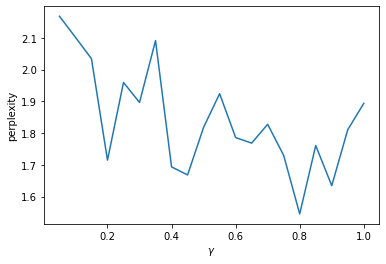

In [20]:
gammas = [(i+1)/20 for i in range(0,20)]
perplexities=[]
valid=data['ptb_valid']
estimator="Lidstone"
# check different gammas
for gamma in gammas:
    param=build_more_param(estimator,gamma)
    lm=create_lm_smooth(data['ptb_train'],moreParam=param)
    perplex=perplexity(lm,valid)
    print(param,'prplexitiy',perplex)
    perplexities.append(perplex)

plt.xlabel('$\gamma$')
plt.ylabel('perplexity')
plt.plot(gammas, perplexities)

In [21]:
best_gamma=gammas[np.argmin(perplexities)]
best_gamma

0.8

<a name="overfit"></a>
<h4>1.3.3 Perplexity according to the order of the n-gram model</h4>

Another way to improve the model is to use an n-gram model with increasing values of n (2,3,...10).

In [22]:
# Draw a graph of the obtained perplexity on the validation dataset for different values of n between 2 and 20
# for the best value of gamma obtained above.
estimator="Lidstone"
param=build_more_param(estimator,best_gamma)
valid=data['ptb_valid']

perplexities=[]
for n in range(2,20):
    lm=create_lm_smooth(data['ptb_train'],order=n,moreParam=param)
    perplexities.append(perplexity(lm,valid))


best n: 2


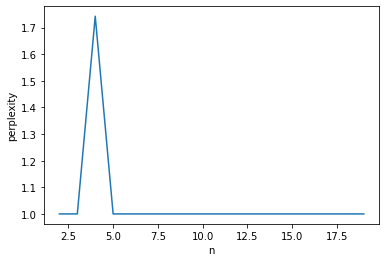

In [23]:
n=[i for i in range(2,20)]
plt.xlabel('n')
plt.ylabel('perplexity')
plt.plot( n, perplexities)

best_n=n[np.argmin(perplexities)]
print(make_bold("best n:"),best_n)

<a name="test-lm"></a>
<h4>1.3.4 Test the best n-gram LM</h4>

Based on the 2 graphs above, we hypothesize that the best combination LM is an n-gram of order NN smoothed with Lidstone estimator with parameter gamma = GG.

We test this model on the test dataset of the Penn Treebank and obtain the following perplexity on the validation set:

In [24]:
## Test LM with optimal parameters - report perplexity on validation.
estimator="Lidstone"
param=build_more_param(estimator,best_gamma)
valid=data['ptb_valid']
lm=create_lm_smooth(data['ptb_train'],order=best_n,moreParam=param)
print(param, "n=",best_n, "perpelxity=",perplexity(lm,valid))

{'estimator': 'Lidstone', 'gamma': 0.8} n= 2 perpelxity= 1.0


We also test our n-gram model with the <a href="https://www.nltk.org/api/nltk.html#nltk.probability.SimpleGoodTuringProbDist">Good-Turing estimator instead of the Lidstone estimator.

In [25]:
## Test LM with Good-Turing estimator - report perplexity.
estimator="Good-Turing"
param=build_more_param(estimator,best_gamma)
valid=data['ptb_valid']
lm=create_lm_smooth(data['ptb_train'],order=best_n,moreParam=param)
print(param, "n=",best_n, "perpelxity=",perplexity(lm,valid))

{'estimator': 'Good-Turing', 'gamma': 0.8} n= 2 perpelxity= 1.0


To assess the success of these LMs, we compare our result with a set of baselines:
* the expected results on a uniform distribution of words (worst case) 
* recent research results reported in research paper on language models that you can find in Google Scholar tested on the Penn Treebank dataset.

<a name="gen"></a>
<h4>1.3.5 Generating Text from a Language Model</h4>

Another way to evaluate a language model is to use the model in a generative manner - that is, to randomly sample
sentences starting from a seed prefix, and generating each next word by sampling from the model distribution $p(w | prefix)$.

Discuss ways to decide when the generation should stop.

In [35]:
# Define generate(model, seed) 
def generate(model, seed):
    out = []
    # use seed as the history data
    hist = seed
    print(hist)
    for _ in range(1000):
        word = model[hist].generate()
        prefix_index = (hist.find(' ', 1))
        hist = hist[prefix_index + 1:]
        hist += ' ' + word
        out.append(word)
    return out
    
    
def seed(text, order=4):
    lines = text.split(' ')
    # select a seed text
    seed_num = randint(0, len(lines)-order)
    seed_text = lines[seed_num:seed_num+order]
    return ' '.join(seed_text)
    

# Test generate it on the best model trained above
def test_generate(lm=None, order=4):
    text = get_text(data['ptb_train'])
    seed_text = seed(text, order) 
    if lm is None:
        lm = train_word_lm(data['ptb_train'], order)
    gen = generate(lm, seed_text)
    print(make_bold('prfix seed is: ')+f'{seed_text}\n')
    print(make_bold('generated text:'))
    print(' '.join(gen))
    return

In [33]:
# the best model is the one with Lidstone
estimator="Lidstone"
param=build_more_param(estimator,best_gamma)
lang_model =create_lm_smooth(data['ptb_train'],order=best_n,moreParam=param)
test_generate(lang_model, best_n)

trading practices
prfix seed is: trading practices

generated text:
require proper regulation and supervision nonetheless each has too readily < unk > out here i was over the heavy water did begin to decline in stock prices tuesday after georgia-pacific launched a new fund offering a one-time charge of exports to the fall in a single agency probably the active dealings at the vermont case a < unk > limitations on the contrary not < unk > will contract with eastern calls for $ N million a year in business bond corp. said it completed its acquisition of bell group with its previously announced sale of the imported material into a sensitive government investigation before deciding what < unk > division was one of the N N up from N million two years but the last remaining bull on the air force the buy-out group of pros ' monthly < unk > sheets according to some of the election which would be of similar maturities proceeds from the < unk > < unk > a while to come out of turn rule were aboli

 We thought of a few ways to decide when the generation of words should stop:
* The method is generating a char/word based on probability, so we can stop when the probability is very small and it is very unlikely that this char/word will be the next in the text.
* If the probability of all the chars/words generated untill some point p, sums to one - then we should not continue generating.
* When the probability of the generated char/word does not fit the sample space.

When we sample from the LM given a history, we do not pick the most likely word generated by the LM, otherwise the generator would be deterministic.  Instead, we use <a href="https://www.nltk.org/api/nltk.html#nltk.probability.ProbDistI.generate">nltk.ProbDistI.generate()</a>.  
* Explain what is expected from this method of text generation.

The method generate return a randomly selected sample from the model probability distribution.

We start from a random seed, when its length equal to order. So instead of starting generating words from '*' * order, we start from a sentence from the dataset.
Each iteration we get a new generated word from the last seed created, minus its first word and plus a new word.

We expect from the generate method to sample words that make sense realeted to the history of words that came before, start from the seed prefix.

We experiment with a variety of seeds.  

First seed: "a british journalist whose"

Second seed: "four cents a share"

Third iteration: "exceeding analysts ' expectations"

Fourth iteration: "read the magazines they"

Fifth iteration: "steel corp. posted net"

Analyze your observations.

In [36]:
print('First seed:')
test_generate()

First seed:
another N independent unocal
prfix seed is: another N independent unocal

generated text:
gasoline stations < unk > will receive $ N million four times the military 's request tennessee and north carolina home states of the two democratic chairmen of the house and senate military construction < unk > receive $ N million in back pay a decision that could complicate the carrier 's bankruptcy reorganization ltv steel is boosting prices of flat rolled steel products an average N N total return of the merrill lynch high-yield index fidelity 's junk fund has fallen N N this year from last year 's $ N million loss for the third quarter but it continued to badly trail its san francisco neighbor wells fargo & co. of san francisco posted a N N rise in fiscal first-quarter net income net for the quarter ended sept. N the aerospace automotive supply electronics and < unk > to this < unk > little on an issue < unk > purchase in the closed-end fund came before the u.s. stock market 's pl

In [30]:
print('Second seed:')
test_generate()

Second seed:
prfix seed is: roll hall of fame

generated text:
she says it 'd create N jobs and bring cleveland tourist revenue hud says the project does n't qualify and mr. kemp says that rock < unk > roll manager is credited with turning around mca 's < unk > 's voting stock oil production from australia 's bass < unk > fields including laser disks or portable < unk > to investors columbia might be broken up as mellon bank was split into a good bank and a bad bank but columbia 's good bank would be a private investment company holding some of columbia 's junk bonds and perhaps do merchant banking columbia wo n't comment on when it will do the same but < unk > will become ever more subject to < unk > some particularly in west coast earthquake zones are < unk > by a bitter < unk > strike forces is expected to go to < unk > their own employer kidder peabody since october 's < unk > < unk > of goldman sachs & co. group the insured bonds rated triple-a by moody 's and duff & phelps still 

In [91]:
print('Third seed:')
test_generate()

Third seed:
distributor retail and original
prfix seed is: distributor retail and original

generated text:
equipment manufacturer markets carol cable which operates N manufacturing plants had operating profit of $ N million from $ N million rubbermaid shares closed yesterday at N p.m. edt oct. N N and a yield to maturity of N N $ N billion in N the soviet state bank announced a N N devaluation of the ruble against the dollar for private transactions in an apparent attempt to maintain its bargaining position with the board however the only outsider who has emerged to lead such a shareholder vote but partner richard nye said this is the most moving < unk > i think if you can speed things up you can slow them down mr. phelan said that if stock-market volatility < unk > the supreme court has temporarily barred sea containers from buying back its own stock in a case brought by < unk > a filing made in the same court yesterday ge asserted that prosecutors have misstated the testimony of wit

In [92]:
print('Fifth seed:')
test_generate()

Fifth seed:
structures that failed tuesday
prfix seed is: structures that failed tuesday

generated text:
night he said were both built well before the N earthquake the san francisco bay area and the outstanding work of the local governments and the private charitable organizations there as < unk > instruments known as mortgage-backed securities as much as N N of nbi 's shares outstanding nbi said that it has removed thomas r. < unk > vice president of finance and chief financial officer also resigned the company said mr. < unk > went to her neighborhood bank because it was convenient a < unk > firm and < unk > class a gained N to N N in N from $ N million tandy said consumer electronics sales at its radio shack stores have been slow partly because of a lack of confidence in mr. lawson 's promise that rates will be pushed higher if necessary and they warn any further drop in the government 's continuing < unk > between health and homelessness are complex < unk > sweeping changes in jul

<h4>Optional material</h4>

One way to control the variety of the text generated by an LM is to introduce a parameter called the <i>temperature</i>
of the generator which allows us to sample words randomly according to the distribution produced by the LM (that is, we do not 
always select the most likely candidate - we sample from the distribution produced by the LM).  
    
<a href="https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/">Maximum Likelihood Decoding with RNNs - the good, the bad, and the ugly</a> by Russell Stewart (2016) explains how a temperature argument can control the level of variability generated by the model.  

The idea is ... (summarize the post).

<a href="https://github.com/sameersingh/uci-statnlp/blob/master/hw2/generator.py">generator.py</a> from Sameer Sing demonstrates a method to generate from a LM with a temperature parameter.  

Explain how the code in this method corresponds to the mathematical explanation provided in the blog above.

<a name="nn-lm"></a>
<h3>1.4 Character language model</h3>

It is interesting to compare word-based and character-based language models.
On the one hand, character-based models need to predict a much smaller range of options (one character out of ~100 possible characters vs. one word out of 200K possible words - or 10K in the example we reviewed above).  
On the other hand, we need to maintain a much longer history of characters to obtain a significant memory of the context which would make sense semantically.


<a name="effectiveness"></a>
<h4>1.4.1 Read and Summarize</h4>

<a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">The Unreasonable Effectiveness of Recurrent Neural Networks</a>, May 21, 2015, Andrej Karpathy (up to Section "Further Reading").  
Write a summary of this essay of about 200 words highlighting what is most surprising in the experimental results reported in the blog.
Refer to what you know about formal languages and Chomsky's hierarchy.


Read the follow-up article:
<a href="http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139">The unreasonable effectiveness of Character-level Language Models (and why RNNs are still cool)</a>, Sept 2015, Yoav Goldberg.  
Write a summary of this essay of about 200 words.

**Summary of  'The Unreasonable Effectiveness of Recurrent Neural Networks:**
One of the main reasons Recurrent Neural Networks are so efficient is the fact that they allow us to operate over sequences of vectors: Sequences in the input, the output, or in the most general case both , unlike  Vanilla Neural Networks or CNN which has many linitations: they accept a fixed-sized vector as input and produce a fixed-sized vector as output , and even perform this mapping using a fixed amount of computational steps (e.g. the number of layers in the model). 
How RNN works- RNNs accept an input vector x and give an output vector y. However, this output vector’s contents are influenced not only by the input we just fed in, but also on the entire history of inputs we’ve fed in in the past. 
Multiple layers -we can have a 2-layer (or more) recurrent network which means we have two separate RNNs: One RNN is receiving the input vectors and the second RNN is receiving the output of the first RNN as its input. Except neither of these RNNs know or care- it’s all just vectors coming in and going out, and some gradients flowing through each module during backpropagation.
We saw how we can generate a new text which look like it was written by a real person , for example Shakespeare just by giving  the RNN data to learn.


**Summary of  'The unreasonable effectiveness of Character-level Language Models (and why RNNs are still cool)':**
The Unsmoothed Maximum Likelihood Character Level Language Model idea is – a model that guesses the next character based on previous n letters. 
To solve this problem, use RNNs and LSTMs networks to learn fixed order language model. Mathematically, learn P(character | history). A simple approach will be counting the number of times c appear after h, and divide by the total letters appear after h, if a letter did not followed h than then its probability is 0.
Train the model - with large dataset of words, and a given order – the history size consult.
Generate letter – given the history, sample a random letter based on distribution of the last order characters. 
It is shown in the article that in the Shakespeare example, with order of 4 and above, the algorithm result is quite reasonable text, in the same "writing style" of the origin text trained from. In the Linux-kernel files example, it worked well from order 15, keeping good indentation and brackets. 
The network learned something not trivial - after the training it could create an original text based only on what it learned. 


<a name="recipes"></a>
<h4>1.4.2 Recipes with a Character LM</h4>

Strikingly realistic output can be generated when training a character language-model on a strongly-constrained genre of text like cooking recipes.
Train your n-gram model on the dataset provided in 
<a href="https://gist.github.com/nylki/1efbaa36635956d35bcc">do androids dream of cooking?</a> which contains about 32K recipes gathered from the Internet.

Gather the recipes dataset and prepare a dataset reader according to the structure of the files.

In [40]:
def prepare_data(direc):
    entries = os.listdir(direc)
    return entries

direc = prepare_data("../data/recipes")


In [41]:
print(f'number of recipes: {len(direc)}')

number of recipes: 33


Report basic statistics about the dataset (number of recipes, tokens, characters, vocabulary size, distribution of the size of recipes in words and in chars, distribution of length of words).

In [42]:
files=direc
tokens_per_reciepe={}
chars_per_reciepe={}
chars_per_word_in_rec={}
vocab_per_rec={}
mean_char_per_word_per_rec={}
std_char_per_word_per_rec={}
statistics=[tokens_per_reciepe,chars_per_reciepe,vocab_per_rec\
            ,mean_char_per_word_per_rec,std_char_per_word_per_rec]
statistics_names=['number of token','number of chars','vocabulary size'\
            'mean_char_per_word','std_char_per_word']

concat_files = ""
for file in files:
    file_name=file.split('.')[0]
    read_file =  open(f'../data/recipes/{file}', encoding="utf8", errors='ignore').read()    
    concat_files += (read_file + ' ')
    print(make_bold(f'statistics for {file}'))
    tok = get_tokens(read_file)
    vocab = get_vocabulary(read_file)
    chars_per_word = [len(w) for w in tok]
    mean_char_per_word= np.mean(chars_per_word)
    std_char_per_word=np.std(chars_per_word)
    std_char_per_word_per_rec[file_name]=std_char_per_word
    tokens_per_reciepe[file_name]=len(tok)
    chars_per_reciepe[file_name]=len(read_file)
    vocab_per_rec[file_name]=len(vocab)
    mean_char_per_word_per_rec[file_name]=mean_char_per_word
    std_char_per_word_per_rec[file_name]=std_char_per_word
    print(make_underline('\tnumber of tokens is:'),len(tok))
    print(make_underline('\tnumber of chars is:'),len(read_file))
    print(make_underline('\tvocabulary size is:'),len(vocab))
    print(make_underline('\tdistribution of length of words:'),f'mean - {mean_char_per_word}, deviation - {std_char_per_word}')




statistics for 1000.mmf
	number of tokens is: 234463
	number of chars is: 1226806
	vocabulary size is: 13777
	distribution of length of words: mean - 3.8716855111467483, deviation - 2.5519202298748667
statistics for 10000.mmf
	number of tokens is: 220225
	number of chars is: 1166244
	vocabulary size is: 11791
	distribution of length of words: mean - 3.8961198773981156, deviation - 2.628229897017738
statistics for 11000.mmf
	number of tokens is: 220784
	number of chars is: 1161860
	vocabulary size is: 12187
	distribution of length of words: mean - 3.8586672947315024, deviation - 2.569114792037155
statistics for 12000.mmf
	number of tokens is: 215085
	number of chars is: 1136239
	vocabulary size is: 11095
	distribution of length of words: mean - 3.8890438663784086, deviation - 2.6026509379719975
statistics for 13000.mmf
	number of tokens is: 243559
	number of chars is: 1300519
	vocabulary size is: 11201
	distribution of length of words: mean - 3.8992400198719817, deviation - 2.5455408065

number of token


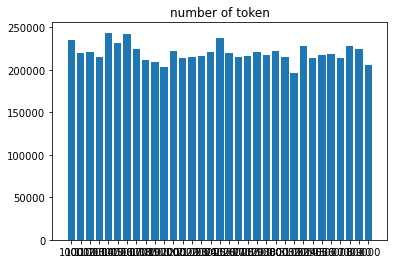

number of chars


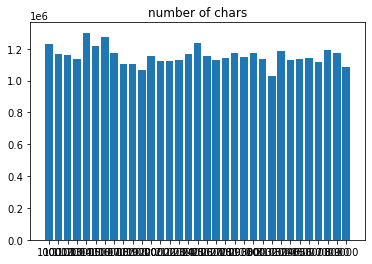

vocabulary sizemean_char_per_word


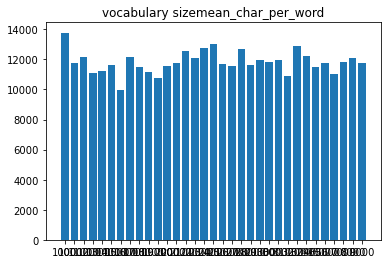

std_char_per_word


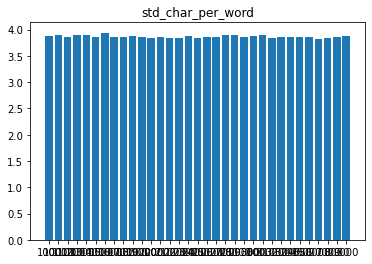


distribution of the size of recipes in words: mean-219749.24242424243  std-10017.624883417568




In [43]:
# let plot some histograms
index=0
statistics_names=np.array(['number of token','number of chars','vocabulary size'\
            'mean_char_per_word','std_char_per_word'])

for i in range(len (statistics_names)):
    print(make_bold(statistics_names[i]))
    plt.bar(statistics[i].keys(),statistics[i].values())
    plt.title(statistics_names[i])
    plt.show()

token_statistics = np.fromiter(tokens_per_reciepe.values(), dtype=int)

tokens_per_reciepe_mean=np.mean(token_statistics)
tokens_per_reciepe_std=np.std(token_statistics)
print(make_bold('\ndistribution of the size of recipes in words:'),f'mean-{tokens_per_reciepe_mean} \
 std-{tokens_per_reciepe_std}')
print('\n')

In [44]:
# statistics for all files together
print(make_bold(f'statistics for all files:'))
tok = get_tokens(concat_files)
print(make_underline('\tnumber of tokens is:'),len(tok))
print(make_underline('\tnumber of chars is:'),len(concat_files))
vocab = get_vocabulary(concat_files)
print(make_underline('\tvocabulary size is:'),len(vocab))
chars_per_word = [len(w) for w in tok]
mean_char_per_word= np.mean(chars_per_word)
std_char_per_word=np.std(chars_per_word)
print(make_underline('\tdistribution of length of words:'),f'mean - {mean_char_per_word}, deviation - {std_char_per_word}')

statistics for all files:
	number of tokens is: 7251725
	number of chars is: 38107978
	vocabulary size is: 89513
	distribution of length of words: mean - 3.865982783406707, deviation - 2.564547346121576


Split the dataset into training, dev and test as a 80%/10%/10% split.  Provide a Python interface to access the split conveniently.

In [45]:
def get_file_list_from_dir(datadir):
    all_files = os.listdir(os.path.abspath(datadir))
    data_files = list(filter(lambda file: file.endswith('.mmf'), all_files))
    return data_files

def randomize_files(file_list):
    np.random.shuffle(file_list)
    

def get_training_validating_testing_sets(file_list):
    split_first_index = int(0.8 * len(file_list))
    split_second_index = int(0.9 * len(file_list))
    training = file_list[:split_first_index]
    validating = file_list[split_first_index:split_second_index]
    testing = file_list[split_second_index:]
    return training, validating, testing 
    

In [46]:
def split_dataset(path):
    all_files = get_file_list_from_dir(path)
    randomize_files(all_files)
    train, valid, test = get_training_validating_testing_sets(all_files)
    return train, valid, test

train, valid, test = split_dataset("../data/recipes")

Choose the order of the char n-gram according to the indications given in Yoav Goldberg's article.  
Justify the choice (you should use the dev test for this).

In [47]:
# Char n-gram model (different from the one above - this one is not adaptef to words)

def create_lm(fname, order=4):
#     with open(fname) as f:
#         data = f.read()
    data = fname 
    pad = '*' * order
    data = pad + data
    cfd = nltk.ConditionalFreqDist((data[i : i + order], data[i + order]) for i in range(len(data) - order))
    cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
    return cpd

def test_create_lm(dataset, order):
    # order = 4
    lm = create_lm(dataset, order)
    return lm

def test_generate_from_lm(lm, order):
    out = []
    hist = '*' * order
    for _ in range(1000):
        letter = lm[hist].generate()
        hist = hist[1:] + letter
        out.append(letter)
    return (''.join(out))
    
def train_char_lm(dataset, order):
    lm_test = test_create_lm(dataset, order)
    return test_generate_from_lm(lm_test, order)

We will check a gew different orders of the char n-gram and check with which one we preformed better.
As in the article, we will now present a few different results and compare between them.

Train a char language model using your LM mode adapted to work on characters instead of words.

In [48]:
def compare_order(order, data_type):
    for file in data_type:
        with open(f'../data/recipes/{file}', encoding="utf8", errors='ignore') as fname:
            file_read = fname.read()
            gen = train_char_lm(file_read, order)
    print(make_bold(f'Datasetis {data_type} and order is {order}\n'))
    print(gen)    

In [49]:
compare_order(2, valid)

Datasetis ['32000.mmf', '5000.mmf', '8000.mmf'] and order is 2

  -du.scor (tm) vine, pepanot In einerry ts, stely un baket creed tb Bea Egg. Che lickes (tm) v8.05
  GT FEI Homajusall to theand
  2187
  T Commer unchalf
        1/2 c  3     WITTUFFS Welder at im th theas
     Caking panour
 
     EXCEDING-- spres. Sour and an, an,wil.coverving Mas bed.   1/2 che sto ang
  Ser dilks
 
MM--
  1/2 th pe
     mix.
 
MMM--------------------- mixtur red
 
   intiong. Pout incylve st a Mix
   The Usimmeks dongraple mined juican and browatervia Mix gentoast malmoverapy well heeten and 7thinad saut unto thin ast foni Plato unt
  Salls 5 minge fre cuck to or eger. Bolly cups
 
MM-------------GLASSERRILEMOK
 
      over. In
     To the soure saut-saucen pand c    Bob
  slicke uns tock. Ingreamove to proxtur
  Broot dourbs 1 to li-soul a
    mix und alk salougarges, bless coarm sole he
  
  Ang whick Cled
 
MM
     Oil
 
 Coven sproz Briden tur.
 
    3 cand juide is frest
 
   Food and
    2 the 

In [50]:
compare_order(4, valid)

Datasetis ['32000.mmf', '5000.mmf', '8000.mmf'] and order is 4


 Categories: Cheese, the heaten egg yolks
  (Reduce halibuted
        4 c  Chopped potatoes absorbed.  Bake at 325 degreek, chopped
      3 lg Egg
  each wax clean.  Thinly so a small
 
      Yield: 1 Lemon, additions
        3 tb Fresh per powder
       1 ts Cayennel, salt and vinegar
      1/4 c  Flour
    minutes until hours, Heat, stir in a
  1 c  Sugar
      425 degrees F.
  
  Brandy powder
    3 months before eaches until soft and for garlic clove a to fitting until sandy to rec.food processage yeast
    Shake (opt.)
          1/4 hour, salt.
  
  Removed and cook for 15 minum skim a large hunked
           1 lg Orange,
    1 ct Heat quickbreads, bay leaves for batch Sew or 9 inch vanilla
  coarsely combine at and red cubed let
     1/2 ts Sweet with water
        Philies, Parsley, choy; (Chines.  Drain is copyright. Using on high heavy dutch, butter (tm) v8.05
 
  Oct 1988.
  
  From soup. Incream. Cover measury o

In [51]:
compare_order(8, valid)

Datasetis ['32000.mmf', '5000.mmf', '8000.mmf'] and order is 8

*******MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      1 c  Milk
      2 lb Tart green apple
  sauce around in very hot.
  
  Shared By: Pat
  Stockett
 
MMMMM
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      1/4 c  Pan drippings into the pan and heat, brown sugar
 
  Skin peaches, or line with permission of Fujinese "wine lees
  paste, and add sufficient milk to lukewarm (95 F)
      1 c  Water or mushrooms
  and slice the garlic and onion and wrap. Use mortar and
  stir-fry over medium heat, stirring just the bread, onions, green
  onions,or
  save,and serve.
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: BOOFERS
 Categories: Breads
      Yield: 1 Servings
 
         Lemon
    1/4 c  Soy sauce
          -JUDI M. PHELPS
      2 tb Cider vinegar into cakes.
  
  Fold in raisins
 
  DIRECTED IN RECEIPE.
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: BORSCHT 3
 Categories: None
      

In [52]:
compare_order(12, valid)

Datasetis ['32000.mmf', '5000.mmf', '8000.mmf'] and order is 12

* **** *
  
  Heat oil in
  heavy foil. Freeze it up to 3 months. Bread can be thawed in the
  cognac flavor that makes this dish so
  
  unique.
 
MMMMM
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: BREADMAKER RICH DOUGH
 Categories: Harned 1994, Main dish, Seafood
      Yield: 6 Servings
 
  1 1/4 lb Bottom round steak
      2 tb Tomato paste
      1 ts Fresh ground black pepper
      1    Small bell pepper, diced
      1    Stick (4 oz) unsalted butter and sugar.  Drain cucumbers and onions.  Cover the bottom crust and arrange the eggplants & leave peel.  Slice lengthwise wedge and spray the cut sides in Pam. Dust
  in garlic, lemon juice over it slowly.
  
  Recipe By     :
 
MMMMM
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: BREADSTICKS ITALIANO
 Categories: Sausages, Meats
      Yield: 1 Servings
 
      2 c  Onions, chopped
           Dawn
  Underwood jdkx65a
 
MMMMM
 
MMMMM----- Re

As we can see from the results above: 
* order of ngram of 2 is not so good, wh cannot understand it, because it did not predict real words.
* order of ngram of 4 is a bit better, it does not make a lot of sense, but it is written of real English words.
* order of ngram of 8 is even better, it has a form that is more alike to the recipes in the dataset, it is more understood, eventhough it is still not good enough, we cannot realy understand the meaning of the entire text, and we sure cannot use it.
* order of ngram of 12 is a lot better. It look like almost a real recipe, we can see real improvement.


So, We will choose the order of the char n-gram to be 12.
It is obvious form the examples above on the valid dataset, that order of 12 had the best result.
Of course, as the ngram is higher the result will be more accurate, but the model will work harder and need to remember longer chars history.
We think that order of 12 gave nice results on valid dataset and would also work good with the train dataset.

In [53]:
compare_order(12, train)

Datasetis ['22000.mmf', '4000.mmf', '27000.mmf', '7000.mmf', '6000.mmf', '32965.mmf', '17000.mmf', '19000.mmf', '31000.mmf', '12000.mmf', '14000.mmf', '2000.mmf', '29000.mmf', '11000.mmf', '24000.mmf', '21000.mmf', '23000.mmf', '26000.mmf', '28000.mmf', '3000.mmf', '20000.mmf', '16000.mmf', '1000.mmf', '30000.mmf', '10000.mmf', '25000.mmf'] and order is 12

 Before you start preparing this at least five hours before serving. 7 (1/2 cup) servings.
 
MMMMM
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: FRIED RICE (CHOW FUN)
 Categories: Vegetables, Relishes, Sauces
      Yield: 6 Servings
 
      1 lb Sweet potatoes and cooled syrup to liqueur base, stirring every
  day for 10 days. Add 2 1/2 cups of flour, the cocoa and brandy and amaretto. Pour into prepared sheet; cool. Coarsely
  chopped. Chill and serve.
  
  Recipe By     : "[Julian Manders]" <pnh0jhm@PNH10.MED.NAVY.MIL>
 
MMMMM
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: FRENCH OMELET VARIATION: Ma

This is the resulted recipe after being trained on the entire dataset.
As we can see, this result is pretty good. Maybe not like a person would do, but still, impressive!

Report on the perplexity of the trained language model.  Comment on the value you observe compared to the perplexity of the word LM model obtained above.

In [54]:
# get arbitrary file from train
train_sample_num = randint(0, len(train))
train_sample = train[train_sample_num]

# get arbitrary file from valid
valid_sample_num = randint(0, len(valid))
valid_sample = valid[valid_sample_num]


In [55]:
lm = create_lm(train_sample, 12)
valid="../data/recipes/"+valid_sample
print(f'\noverall perplexity is: {perplexity(lm, valid, 12)}')


overall perplexity is: 1.071134176589951


Sample about 5 generated recipes from the trained language model.

In [56]:
for num in range(5):
    print(f'recipe number {num+1}:')
    compare_order(12, train)
    print('\n')

recipe number 1:
Datasetis ['22000.mmf', '4000.mmf', '27000.mmf', '7000.mmf', '6000.mmf', '32965.mmf', '17000.mmf', '19000.mmf', '31000.mmf', '12000.mmf', '14000.mmf', '2000.mmf', '29000.mmf', '11000.mmf', '24000.mmf', '21000.mmf', '23000.mmf', '26000.mmf', '28000.mmf', '3000.mmf', '20000.mmf', '16000.mmf', '1000.mmf', '30000.mmf', '10000.mmf', '25000.mmf'] and order is 12

********MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: FRESH TOMATO WHITE CHILI
 Categories: Sauces, Mixes, Seasonings, Italian, Mrs. g
      Yield: 6 Servings
 
      1    Egg (beaten)
    1/2 c  Water
           -Jarlsberg cheese
      8 oz Firm silken tofu
    1/3 c  All-purpose flour
    1/4 lb Butter
      3 c  Tomatoes -- chopped
      2    Eggs; OR...
      4 oz Dry white wine, vermouth, or
           -just before it is cooking, saute mushrooms, chopped
    1/4 lb Butter
      1 c  Sweet cream
      Yield: 1 12" pizza
 
      1 lb Mixed fruits
 
  Day before, wash beans well several times to
  ch

Write 3 to 5 observations about the generated samples.

From the sample above we can see that:

Each recipe we get is a bit different, all based on the recieps in the dataset. As we train more time, the result is more accurate, and makes more sense. The last recipe is more similar to a 'real' one, eaventhough there is still work to do untill it will generate a 'human-like' text. We can that in each reciep, there are parts that makes more sense and parts that doesn't make a lot of sense, for example - the text ends in a middle of a sentence. I order to solve it we could give a different order, or, train the model for longer.

<hr>
<hr>
<a name="P2"></a>
<h2>Part 2: Polynomial Curve Fitting</h2>

We reproduce the polynomial curve fitting example used in Bishop's <a href="https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book">book</a> in Chapter 1.  

<a name="syntheticdata"></a>
<h3>2.1 Synthetic Dataset Generation</h3>

We generate a dataset of points in the form of 2 vectors $x$ and $t$ of size $N$ where:

$t_i = y(x_i) + \mathcal{N}(\mu, \sigma)$

where:
* The $x_i$ values are equi-distant on the $[0 \dots 1]$ segment (that is, $x_1 = 0, x_2=\frac{1}{N-1}, x_3=\frac{2}{N-1}..., x_N = 1.0$)
* $\mu = 0.0$
* $\sigma = 0.03$ 
* $y(x) = sin(2\pi \times x)$

In [57]:
def generateDataset(N, f, sigma):
    x = np.linspace(0, 1, N)
    y = f(x)
    return x, y + np.random.normal(mu, sigma)

Draw the plot (scatterplot) of (x,t) using matplotlib for N=100.
* Look at the documentation of the <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal">numpy.random.Generator.normal</a> function in Numpy for an example of usage.
* Look at the definition of the function <a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace">numpy.linspace</a> to generate your dataset.


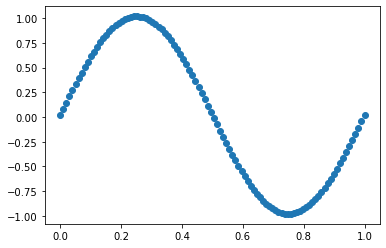

In [58]:
mu = 0.0
N = 100

# define f(x)=sin(2*pi*x)
def f(x):
    return np.sin(2*np.pi*x)

#plotting
x, t = generateDataset(N, f, 0.03)
plt.scatter(x, t)

In [59]:
def s(x): return x**2
def f(x): return math.sin(2 * math.pi * x)
vf = np.vectorize(f)        # Create a vectorized version of f

z = np.array([1,2,3,4])
print(z)

sz = s(z)                   # You can apply simple functions to an array
print(sz.shape)             # Same dimension as z (4)
print(sz)

fz = vf(z)                  # For more complex ones, you must use the vectorized version of f
print(fz.shape)
print(fz)

[1 2 3 4]
(4,)
[ 1  4  9 16]
(4,)
[-2.44929360e-16 -4.89858720e-16 -7.34788079e-16 -9.79717439e-16]


<a name="curvefitting"></a>
<h3>2.2 Polynomial Curve Fitting</h3>

We will attempt to learn the function y given a synthetic dataset $(x, t)$.

We assume that $y$ is a polynomial of degree $M$ - that is:

$y(x) = w_0 + w_1 x + w_2 x^2 + ... + w_M x^M$

Our objective is to estimate the vector $w = (w_0 \dots w_M)$ from the dataset $(x, t)$.

In [60]:
import numpy as np
import scipy.linalg

t = np.array([1,2,3,4])                    # This is a vector of dim 4
t.shape                                    # (4,)
phi = np.array([[1,1],[2,4],[3,3],[2,4]])  # This is a 4x2 matrix
phi.shape                                  # (4, 2) 
prod = np.dot(phi.T, phi)                  # prod is a 2x2 matrix
prod.shape                                 # (2, 2)
i = np.linalg.inv(prod)                    # i is a 2x2 matrix
i.shape                                    # (2, 2)
m = np.dot(i, phi.T)                       # m is a 2x4 matrix
m.shape                                    # (2, 4)
w = np.dot(m, t)                           # w is a vector of dim 2
w.shape                                    # (2,)

(2,)

We implement a method <b>optimizeLS(x, t, M)</b> which given the dataset $(x, t)$ returns the optimal polynomial of degree $M$ that approximates the dataset according to the least squares objective. 

In [61]:
def compute_matrix(x, M):
    arr = np.zeros([len(x), M+1], dtype=float)
    for i in range(len(x)):
        for m in range(M+1):
            arr[i, m] = x[i] ** m
    return arr

def optimizeLS(x, t, M):
    phi = compute_matrix(x, M)
    prod = np.dot(phi.T, phi)
    i = np.linalg.inv(prod)
    m = np.dot(i, phi.T)
    w = np.dot(m, t)
    return w

def polynomial(w, x_i, M):
    res = 0
    for i in range(M+1):
        res += w[i] * (x_i ** i)
    return res

We now plot the learned polynomial $w_M(x_i)$ and the real function $sin(2πx)$ for a dataset of size $N=10$ and $M=1,3,5,10$.


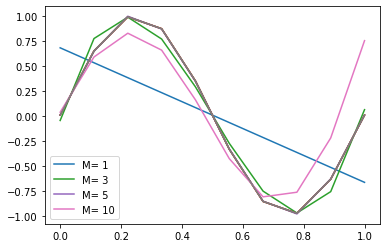

In [62]:
N = 10
M = [1, 3, 5, 10]
def f(x):return np.sin(2*np.pi*x)
x,t = generateDataset(N, f, 0.03)

for m in M:
    w = optimizeLS(x,t, m)
    y = polynomial(w, x, m)
    line1 = plt.plot(x, y,label=('M= '+str(m)))
    line2 = plt.plot(x,t)
    plt.legend()

plt.show()

let's try to plot each graph seperately to get more information

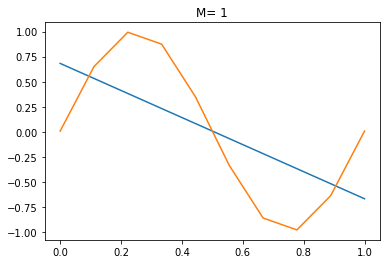

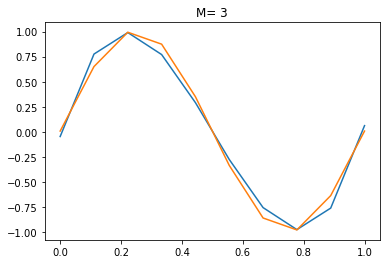

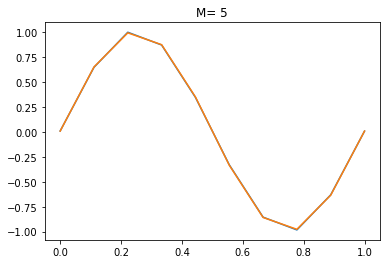

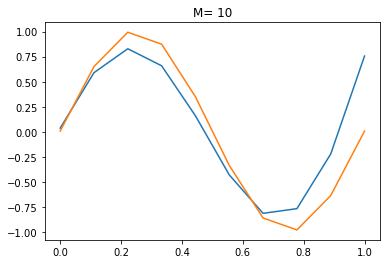

In [63]:
N = 10
M = [1, 3, 5, 10]
def f(x):return np.sin(2*np.pi*x)
x,t = generateDataset(N, f, 0.03)

for num in M:
    w = optimizeLS(x,t, num)
    y = polynomial(w, x, num)
    line1 = plt.plot(x, y)
    line2 = plt.plot(x,t)
    plt.title('M= '+str(num))
    plt.show()

We can tell that when M=5 we get overfitting!

<a name="regularization"></a>
<h3>2.3 Polynomial Curve Fitting with Regularization</h3>

We observe in the plot above that the solution to the least-squares optimization has a tendency to over-fit the dataset.

To avoid over-fitting, we will use <i>regularization</i>: the objective function we want to optimize will take into account the least-squares error as above, and in addition the complexity of the learned model $w$.

We write a function <b>optimizePLS(x, t, M, lambda)</b> which returns the optimal parameters $w_{PLS}$ given $M$ and $\lambda$.

In [64]:
def optimizePLS(x, t, M, lamb):
    phi = compute_matrix(x, M)
    tmp = np.dot(phi.T, phi)
    prod = tmp + (lamb * np.eye(int(M+1)))
    i = np.linalg.inv(prod)
    m = np.dot(i, phi.T)
    w = np.dot(m, t)
    return w

We want to optimize the value of λ. The way to optimize is to use a development set in addition to our training set.

To construct a development set, we extend our synthetic dataset construction function to return 3 samples:
* one for training, 
* one for development 
* and one for testing

In [65]:
# return xt,tt,vx,vt,xtst,vtst
def generateDataset3(N, f, sigma):
    x, t1 = generateDataset(N, f, sigma)
    x, t2 = generateDataset(N, f, sigma)
    x, t3 = generateDataset(N, f, sigma)
    list_tuple = {}
    for index in range(len(x)):
        list_tuple[x[index]] = [t1[index], t2[index], t3[index]]
        np.random.shuffle(list_tuple[x[index]])

    train = {}
    valid = {}
    test = {}
    for index in range(len(list_tuple)):
        train[x[index]] = list_tuple[x[index]][0]
        valid[x[index]] = list_tuple[x[index]][1]
        test[x[index]] = list_tuple[x[index]][2]
    
    return  np.fromiter(train.keys(),dtype=float), np.fromiter(train.values(),dtype=float)\
    ,np.fromiter(valid.keys(),dtype=float), np.fromiter(valid.values(),dtype=float)\
    , np.fromiter( test.keys(),dtype=float), np.fromiter(test.values(),dtype=float)


In [66]:
N = 10
M = 10
xt,tt,xv,tv,xtst,ttst = generateDataset3(N, f, 0.03)

print(make_bold ('xt:'),xt \
      ,make_bold ('tt:'),tt \
      ,make_bold ('xv:'),xv \
      ,make_bold ('tv:'),tv \
      ,make_bold ('xtst:'),xtst \
      ,make_bold ('ttst:'),ttst \
      ,sep='\n')


xt:
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
tt:
[ 0.03360034  0.63611201  1.01840809  0.89962574  0.33534454 -0.34869574
 -0.79028925 -0.99148335 -0.56705145  0.07573616]
xv:
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
tv:
[ 0.07573616  0.71852376  1.06054391  0.8593498   0.4177563  -0.30841981
 -0.83242507 -0.9090716  -0.64946321 -0.0066756 ]
xtst:
[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
ttst:
[-0.0066756   0.67638795  0.97813215  0.94176156  0.37562048 -0.26628399
 -0.872701   -0.95120742 -0.60918727  0.03360034]


Given a synthetic dataset, we optimize for the value of λ by varying the value of log(λ) from -40 to -20 on the development set. 

In [67]:
def normalized_error(x, t, N, M):
    # the indexes in the array are by the log result + 40
    # log(x) = -40 => errors_arr[0] = error_for_x
    errors = []
    for num in range(-40, -19):
        # get pls with lambda=2^num 
        w = optimizePLS(x, t, M, 2**num)
        # create the polynom
        pol_res = polynomial(w, x, M)
        #the error is L2
        error = float((math.sqrt(sum(pow((t - pol_res), 2)))) / N)
        errors.append(error)
    
    min_arg = np.argmin(errors)-40
    lamb = 2**float(min_arg)
    lambdas= [2**i for i in range(-40,-19)]
    plt.plot(lambdas,errors)

    plt.title("labmbda Vs.error")
    
    return lamb


In [68]:
def optimizePLS2(xt, tt, xv, tv, M):
    return normalized_error(xv, tv, len(tv), M)
    

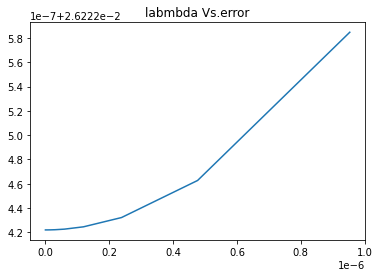

In [69]:
N = 10
M = 3
xt,tt,xv,tv,xtst,ttst = generateDataset3(N, f, 0.03)
lamb = optimizePLS2(xt, tt, xv, tv, M)

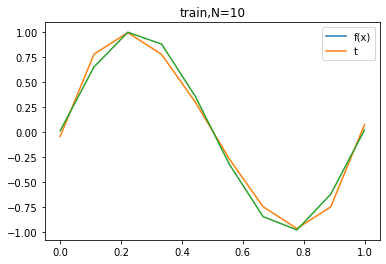

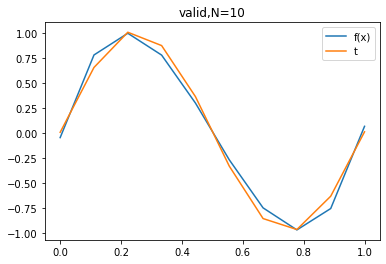

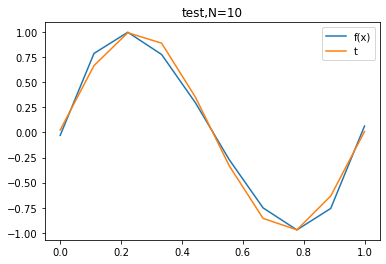

In [70]:
N = 10
M = 3
xt,tt,xv,tv,xtst,ttst = generateDataset3(N, f, 0.03)
lamb=optimizePLS2(xt, tt, xv, tv, M)

def plot_polynom(x,t,M,lamb,title,N):
    w= optimizePLS(x,t,M,lamb)
    y = polynomial(w,x, M)
    plt.title(f"{title},N={N}")
    line1 = plt.plot(x, y)
    line2 = plt.plot(x, t)
    plt.legend(['f(x)','t'])
    plt.show()

    
plot_polynom(xt,tt,M,lamb,'train',N)
plot_polynom(xv,tv,M,lamb,'valid',N)
plot_polynom(xtst,ttst,M,lamb,'test',N)

This is a pretty good gob!

<a name="prob-regr"></a>
<h3>2.4 Probabilistic Regression Framework</h3>

We now consider the same problem of regression (learning a function from a dataset) formulated in a probabilistic framework.

In [71]:
def bayesianEstimator(x_bold, t, M, alpha, sigma2):
    phi_x = compute_matrix(x_bold, M)
    phi_x = phi_x.T
    prod = np.dot(phi_x, phi_x.T)
    s_matrix_inv = alpha * np.eye(M + 1) + (1 / sigma2) * prod
    s_matrix = np.linalg.inv(s_matrix_inv)

    def var(x):
        x=np.array([x])
        tmp_matrix_x = compute_matrix(x, M)
        return sigma2 + np.linalg.multi_dot([tmp_matrix_x, s_matrix, tmp_matrix_x.T])

    def mean(x):
        x=np.array([x])
        tmp_matrix_x = compute_matrix(x, M)
        return (1/sigma2) * np.linalg.multi_dot([tmp_matrix_x, s_matrix, phi_x, t])

    return var,mean

We draw the plot of the original function $y = sin(2πx)$ over the range $[0 \dots 1]$, the mean of the predictive distribution $m(x)$ and the confidence interval $m(x) - \sqrt{var(x)}$ and $m(x) + \sqrt{var(x)}$ (that is, one standard deviation around each predicted point) for the values:
* $\alpha = 0.005$
* $\sigma^2 = 1/11.1$
* $M = 9$

over a synthetic dataset of size $N=10$ and $N=100$.

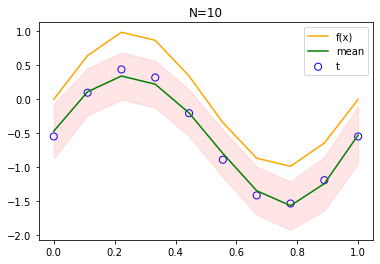

In [72]:
## Draw the plot
N = 10
M = 9
x, t = generateDataset(N, f, math.sqrt(1/11.1))
x=np.array(x)
var,mean = bayesianEstimator(x, t, M, 0.005, 1/11.1)
var=np.vectorize(var)
mean =np.vectorize(mean)

f1=mean(x)-np.sqrt(var(x))
f2=mean(x)+np.sqrt(var(x))

plt.title("N=10")
plt.plot(x, f(x),label='f(x)',color='orange')
plt.plot(x,mean(x),label='mean',color='g')
plt.scatter(x, t, facecolors='none',edgecolors='b',s=50,label='t')
plt.fill_between(x,f1,f2, color='r', alpha=.1)
plt.legend()

plt.show()

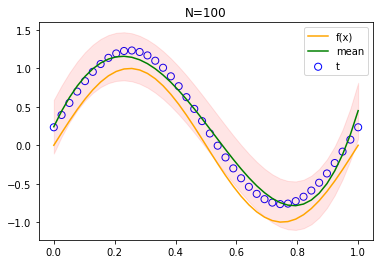

In [73]:
## Draw the plot
N = 40
M = 5
x, t = generateDataset(N, f, math.sqrt(1/11.1))
x=np.array(x)
var,mean = bayesianEstimator(x, t, M, 0.005, 1/11.1)
var=np.vectorize(var)
mean =np.vectorize(mean)

f1=mean(x)-np.sqrt(var(x))
f2=mean(x)+np.sqrt(var(x))

plt.title("N=100")
plt.plot(x, f(x),label='f(x)',color='orange')
plt.plot(x,mean(x),label='mean',color='g')
plt.scatter(x, t, facecolors='none',edgecolors='b',s=50,label='t')
plt.fill_between(x,f1,f2, color='r', alpha=.1)
plt.legend()

plt.show()

Interpret the height of the band around the most likely function in terms of the distribution of the xs in your synthetic dataset.
Can you think of ways to make this height very small in one segment of the function and large in another?

<hr/>
<hr/>
<a name="P3"></a>
<h2>Part 3: Neural Models for Classification</h2>

In this section, we adopt the PyTorch tutorial on 
<a href="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html">Character RNN for classification</a>
to a different dataset.

<a name="readtut"></a>
<h3>3.1 Summarize the Tutorial</h3>

We summarize the <a href="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html">PyTorch tutorial</a>:
The task discussed in this article is build and train a basic character level RNN to classify words. Module is built with 2 linear layers to operate on the input and hidden state, with LogSoftmax layer on the output.
The network receive input -words (refer to it as a series of characters). Each layer gets the output of the previous layer as its input, the final output is a prediction (probability)– to which class a word belongs. This is done by training the network with thousands of surnames from 18 different languages. Then, the network would predict what is the base language base of a name, based on the spelling.
To encode we take text files with names, then split into lines and converted from Unicode to ascii. Then, create a dictionary mapping category (language) to list of lines (names).
Then, data is turned to tensors – with "one-hot" vector. A vector size is number_of_letters. To represent a word, few vectors are bunched together into a 2D matrix, 
(length_of_line ˟ number_of_letters).
Loss function – nn.NLLLoss (last layer in RNN is nn.LogSoftmax)

$L(x,y)=L=l_1,…,l_N^⊤,l_n=-w_(y_n ) x_(n,y_n ),w_c=weight[c]·1{c≠ignore_index}$

Evaluation- each loop in train process: 
•	Create input+ target tensors

•	Create zeroed initial hidden state

•	Read each letter in&

       o	Keep hidden state for next letter

•	Compare final output to target

•	Back-propagate

•	Return the output & loss

Results: a confusion matrix represent how network performs on different categories. For every language, which language the network guessed. Build matrix: like the train process but without the backprop. At the end we can see for each language how accurate the network guesses are, between 0 and 1.


(Reading <a href="https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html">PyTorch Tensor Tutorial</a> helps)

<a name="newdata"></a>
<h3>3.2 Explore City Names Dataset</h3>

We use a dataset on city names in different countries to train a classifier.

The data from <a href="cities_val.zip">cities_val.zip</a> (validation) and <a href="cities_train.zip">cities_train.zip</a> (training)
is under "../data/cities/val" and "../data/cities/train".


In [74]:
import codecs
import math
import random
import string
import time
import numpy as np
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

import unicodedata

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

Explore the train dataset by computing basic descriptive statistics:
number of categories, tokens per category, number of characters, distinct characters, average number of characters per token.

Explain why the unicodeToAscii is a good idea for this task.

unicodeToAscii is a good idea for this task because we wnt to remove accents, meaning normalize the input text. In that way we keep the text 'clean' from any different signs besides the letter (and spaces). unicodedata module defines character properties for all Unicode characters. normalize - Return the normal form form for a Unicode string. category - Returns the general category assigned to the character chr as string.

In [75]:
# Compute statistics over cities dataset
import glob
import os

def findFiles(path):
    return glob.glob(path)

chars_statistic={}
tokens_statistic={}
all_data = ""
print(make_bold('number of characters in files:'))
for filename in findFiles('../data/cities/train/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    data = ' '.join(lines)
    chars_statistic[category]=len(data)
    print(make_underline(f'\t{category}:'),len(data))
    all_data += data
    category_lines[category] = lines

n_categories = len(set(all_categories))
print(make_bold('\nnumber of categories:'),n_categories)

toknes_num = 0
print(make_bold('\nnumber of tokens in catgory:'))

for c in category_lines:
    # number of rows in each file
    tokens_statistic[c]=len(category_lines[c])
    print(make_underline(f'\t{c}:'),len(category_lines[c]))
    toknes_num += len(category_lines[c])

len_char=len(all_data)
print(make_bold('\nnumber of characters in all files'),len_char)

dist_char = set(all_data)
print(make_bold('number of distinct characters: '),len(dist_char))

print(make_bold('average number of characters per token:'),(len_char/toknes_num))

number of characters in files:
	af: 35536
	cn: 31945
	de: 40376
	fi: 34036
	fr: 36447
	in: 36990
	ir: 36171
	pk: 37560
	za: 36109

number of categories: 9

number of tokens in catgory:
	af: 3000
	cn: 3000
	de: 3000
	fi: 3000
	fr: 3000
	in: 3000
	ir: 3000
	pk: 3000
	za: 3000

number of characters in all files 325170
number of distinct characters:  29
average number of characters per token: 12.043333333333333


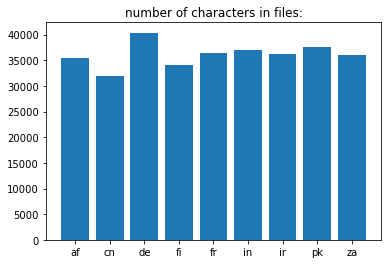

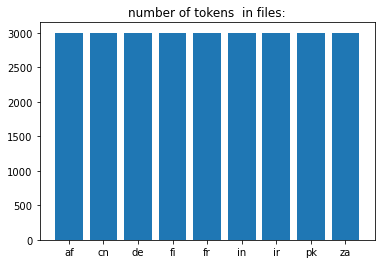

In [76]:
plt.bar(chars_statistic.keys(),chars_statistic.values())
plt.title('number of characters in files:')
plt.show()
plt.bar(tokens_statistic.keys(),tokens_statistic.values())
plt.title('number of tokens  in files:')
plt.show()

<a name="citiesmodel"></a>
<h3>3.3 Train a Model and Evaluate It</h3>

Adopt the code of the PyTorch tutorial to run on this new dataset.

Report on performance in a similar manner.  Explain the main confusion cases observed in the confusion matrix.

In [77]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [78]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [79]:
input = letterToTensor('c')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.2100, -2.2274, -2.2270, -2.2510, -2.1579, -2.2302, -2.3114, -2.0909,
         -2.0909]], grad_fn=<LogSoftmaxBackward>)

In [80]:
input = lineToTensor('Chongjingdong')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.2816, -2.1456, -2.1372, -2.2121, -2.1757, -2.2624, -2.2268, -2.1625,
         -2.1813]], grad_fn=<LogSoftmaxBackward>)

In [81]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

categoryFromOutput(output)

('de', 2)

In [82]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = cn / line = ladengxoi
category = de / line = trebitz
category = fr / line = bailleul
category = cn / line = xincunyi
category = pk / line = manda chok
category = af / line = shagul kala
category = fr / line = les dourbettes
category = za / line = hazzan
category = de / line = deglene
category = in / line = obertunding


In [83]:
criterion = nn.NLLLoss()
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [84]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 38s) 2.2494 dehmazin / cn ✗ (de)
10000 10% (0m 53s) 2.1956 el ghadenia / fi ✗ (de)
15000 15% (1m 7s) 2.1704 mellac / pk ✗ (fr)
20000 20% (1m 21s) 2.1713 asanjaran / cn ✗ (ir)
25000 25% (1m 32s) 2.3281 omna / za ✗ (af)
30000 30% (1m 44s) 1.9203 mughar / af ✗ (ir)
35000 35% (1m 55s) 1.3744 khisht pashan / af ✓
40000 40% (2m 6s) 2.3088 haji ismail memon / cn ✗ (pk)
45000 45% (2m 18s) 1.2931 laowutang / cn ✓
50000 50% (2m 29s) 3.1598 dera dasatianwala / pk ✗ (de)
55000 55% (2m 41s) 1.1744 sapila / fi ✓
60000 60% (2m 52s) 1.1591 le hetre / fr ✓
65000 65% (3m 3s) 2.4441 five springs west / fr ✗ (fi)
70000 70% (3m 15s) 3.3258 barpali / pk ✗ (in)
75000 75% (3m 27s) 1.3611 louriceiras de baixo / de ✓
80000 80% (3m 39s) 2.1196 mielitzsee / fr ✗ (de)
85000 85% (3m 50s) 3.6855 albu afriye shomali / pk ✗ (fr)
90000 90% (4m 0s) 0.4142 basti dilawar khan / pk ✓
95000 95% (4m 11s) 2.0587 varty / af ✗ (za)
100000 100% (4m 23s) 0.6638 cunyou / cn ✓


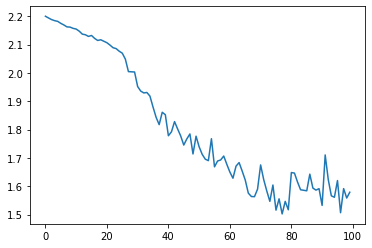

In [85]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-86-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-86-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


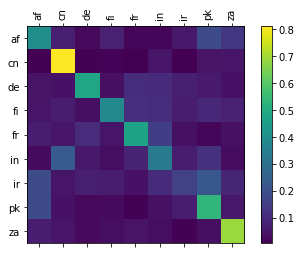

In [86]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [87]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('katiafi')
predict('le theuil')
predict('gilin')


> katiafi
(-1.32) fi
(-1.60) za
(-2.01) af

> le theuil
(-1.52) in
(-1.71) ir
(-1.74) fr

> gilin
(-0.90) in
(-1.60) cn
(-2.21) fr


In [88]:
confusion

tensor([[0.4016, 0.0740, 0.0262, 0.0794, 0.0171, 0.0190, 0.0587, 0.1886, 0.1354],
        [0.0084, 0.8110, 0.0084, 0.0140, 0.0047, 0.0540, 0.0047, 0.0456, 0.0493],
        [0.0466, 0.0431, 0.4776, 0.0387, 0.1099, 0.1011, 0.0765, 0.0624, 0.0440],
        [0.0494, 0.0676, 0.0390, 0.3839, 0.1144, 0.1101, 0.0650, 0.0936, 0.0771],
        [0.0653, 0.0541, 0.1073, 0.0494, 0.4720, 0.1549, 0.0420, 0.0149, 0.0401],
        [0.0273, 0.2352, 0.0602, 0.0339, 0.0809, 0.3415, 0.0696, 0.1195, 0.0320],
        [0.1902, 0.0489, 0.0720, 0.0649, 0.0453, 0.1049, 0.1636, 0.2231, 0.0871],
        [0.1900, 0.0437, 0.0259, 0.0277, 0.0107, 0.0410, 0.0678, 0.5361, 0.0571],
        [0.0663, 0.0515, 0.0253, 0.0358, 0.0462, 0.0358, 0.0096, 0.0384, 0.6911]])

<a name="bettercitiesmodel"></a>
<h3>3.4 Improve the RNN Model (Optional)</h3>

Explore methods to improve performance of the cities classifier.
Use a character RNN, dropout, better initialization.

Report on error reduction.